<a href="https://colab.research.google.com/github/Calcifer777/learn-rl/blob/main/01_reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash

apt install xvfb python-opengl ffmpeg

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following additional packages will be installed:
  freeglut3 libfontenc1 libpython2-stdlib libxfont2 libxkbfile1 python2
  python2-minimal x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libfontenc1 libpython2-stdlib libxfont2 libxkbfile1 python-opengl
  python2 python2-minimal x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 14 newly installed, 0 to remove and 24 not upgraded.
Need to get 8,318 kB of archives.
After this operation, 18.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-minimal amd64 2.7.17-2ubuntu4 [27.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libpython2-std

In [2]:
!pip install gym-notebook-wrapper renderlab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.9 MB/s eta 0:00:00


In [3]:
from datetime import datetime
from torch.distributions import Categorical

import gymnasium as gym

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import renderlab

In [4]:
ts = datetime.utcnow().isoformat()
env_id = 'CartPole-v1'

env = gym.make(env_id, render_mode="rgb_array")

In [5]:
discount_factor = 0.99

In [6]:
class Policy(nn.Module):

    def __init__(self, in_dim, out_dim, hidden_dim=256):
        super(Policy, self).__init__()
        layers = [
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        ]
        self.model = nn.Sequential(*layers)

    def onpolicy_reset(self):
        self.log_probs = []
        self.rewards = []

    def forward(self, x):
        pdparam = self.model(x)
        return pdparam

    def act(self, state):
        x = torch.from_numpy(state.astype(np.float32)) # to tensor
        logits = self.forward(x) # forward pass
        action_prob_dist = Categorical(logits=logits) # probability distribution
        action = action_prob_dist.sample() # pi(a|s) in action via pd
        log_prob = action_prob_dist.log_prob(action) # log_prob of pi(a|s)
        self.log_probs.append(log_prob) # store for training
        return action.item()

In [15]:
def train(policy, optimizer, baseline=True):
    # Inner gradient-ascent loop of REINFORCE algorithm
    T = len(policy.rewards)
    rets = np.empty(T, dtype=np.float32) # the returns
    future_ret = 0.0
    # compute the returns efficiently
    for t in reversed(range(T)):
        future_ret = policy.rewards[t] + discount_factor * future_ret
        rets[t] = future_ret
    rets = torch.tensor(rets)
    if baseline is True:
      rets /= torch.mean(rets)
    log_probs = torch.stack(policy.log_probs)
    loss = - log_probs * rets # gradient term; Negative for maximizing
    loss = torch.sum(loss)
    optimizer.zero_grad()
    loss.backward() # backpropagate, compute gradients
    optimizer.step() # gradient-ascent, update the weights
    return loss

In [16]:
def play_episode(env, policy):
  policy.onpolicy_reset()
  state, info = env.reset()
  for t in range(T):
    action = policy.act(state)
    state, reward, done, _, _ = env.step(action)
    policy.rewards.append(reward)
    if done:
      break

In [17]:
in_dim = env.observation_space.shape[0] # 4
out_dim = env.action_space.n # 2
policy = Policy(in_dim, out_dim) # policy pi_theta for REINFORCE

optimizer = optim.Adam(policy.parameters(), lr=0.002)

In [18]:
NUM_EPISODES = 1000
T = 500

pbar = tqdm()
history = dict(score=[])
for episode in range(NUM_EPISODES):
    play_episode(env, policy)
    loss = train(policy, optimizer) # train per episode
    history["score"].append(int(sum(policy.rewards)))
    if episode % 50 == 0:
      print(
          f"Episode {episode}, "
          f"loss: {loss}, "
          f"max steps: {int(sum(policy.rewards))}, "
          f"solved: {sum(policy.rewards) > T - 10}"
      )

0it [00:29, ?it/s]


Episode 0, loss: 8.7614164352417, max steps: 13, solved: False
Episode 20, loss: 10.539721488952637, max steps: 16, solved: False
Episode 40, loss: 22.44862174987793, max steps: 34, solved: False
Episode 60, loss: 37.19854736328125, max steps: 57, solved: False
Episode 80, loss: 14.396648406982422, max steps: 24, solved: False
Episode 100, loss: 12.465841293334961, max steps: 17, solved: False
Episode 120, loss: 32.302772521972656, max steps: 52, solved: False
Episode 140, loss: 24.523639678955078, max steps: 42, solved: False
Episode 160, loss: 71.1115493774414, max steps: 131, solved: False
Episode 180, loss: 132.78688049316406, max steps: 236, solved: False
Episode 200, loss: 24.006868362426758, max steps: 47, solved: False
Episode 220, loss: 21.044458389282227, max steps: 40, solved: False
Episode 240, loss: 19.152517318725586, max steps: 30, solved: False
Episode 260, loss: 14.2142972946167, max steps: 26, solved: False
Episode 280, loss: 74.85738372802734, max steps: 144, solved:

In [30]:
def running_mean(x, N = 50):
  kernel = np.ones(N)
  conv_len = x.shape[0]-N
  y = np.zeros(conv_len)
  for i in range(conv_len):
    y[i] = kernel @ x[i:i+N]
    y[i] /= N
  return y

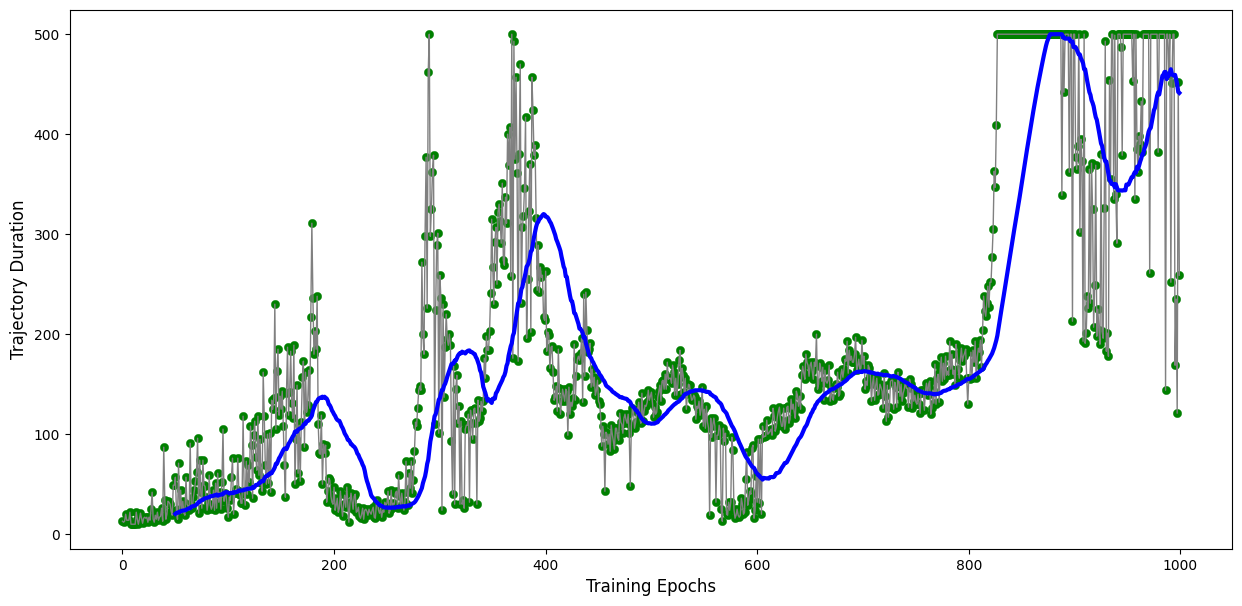

In [31]:
score = np.array(history["score"])
plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.scatter(
  np.arange(score.shape[0]),
  score, 
  color='green', 
  linewidth=0.3
)

window = 50
avg_score = running_mean(score, window)
plt.plot(np.arange(len(avg_score))+window, avg_score, color='blue', linewidth=3)

In [32]:
env_rendered = renderlab.RenderFrame(env, directory=f"./{env_id}-{ts}")
play_episode(env_rendered, policy)
env_rendered.play()

0it [08:12, ?it/s]

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4




t:  97%|█████████▋| 350/360 [00:01<00:00, 168.44it/s, now=None]
0it [08:14, ?it/s]

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
